In [1]:
%matplotlib inline

import os
import glob
import json
import time
import copy
import pickle
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from PIL import Image, ImageDraw
import bcolz

import config
import utils

In [2]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [3]:
def csv_predictions_to_array(path):
    frame = pd.read_csv(path)
    d = {}
    for index, row in frame.iterrows():
        d[row['image']] = np.array(row[:-1], dtype=np.float32)
    return np.array([d[k] for k in sorted(d)])


def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2], box[3],
                         color=color, fill=False, linewidth=2)


def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))

In [4]:
info_string = 'fish'
index = 0
prefix = os.path.join('cache', info_string + '_' + str(index))

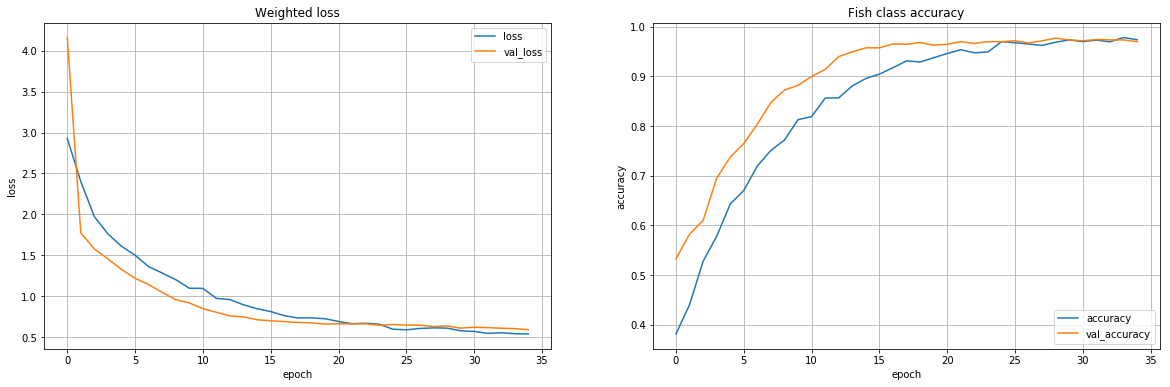

In [15]:
history = pickle.load(open(prefix + '_history.p', 'rb'))

plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history['class_acc'], label='accuracy')
plt.plot(history['val_class_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [14]:
real = csv_predictions_to_array('test_stg1.csv')
pred = csv_predictions_to_array('cache/fish_0_2017-02-06-11-21.csv')

diff = 0
for i in range(len(real)):
    if np.argmax(real[i]) != np.argmax(pred[i]):
        diff += 1

print('Diff:', diff)
print('Log loss:', log_loss(real, pred))

Diff: 308
Log loss: 1.79427412078


In [8]:
X_test = utils.load_array('X_test.bcolz')
Id_test = utils.load_array('Id_test.bcolz')
y_test_bb_tl = utils.load_array('y_test_bb_tl.bcolz')
y_test_bb_wh = utils.load_array('y_test_bb_wh.bcolz')

print('X_test:', np.shape(X_test))
print('Id_test:', np.shape(Id_test))
print('y_test_bb_tl:', np.shape(y_test_bb_tl))
print('y_test_bb_wh:', np.shape(y_test_bb_wh))

Id_test_argsort = np.argsort(Id_test)

def show_pred(i):
    plt.figure(figsize=(9, 12))
    plot(X_test[Id_test_argsort[i]])
    ax = plt.gca()
    print('Id: ', Id_test[Id_test_argsort[i]])
    p = pred[i]
    print('Pred: {} ({:.3f})'.format(classes[np.argmax(p)], p[np.argmax(p)]))
    print('Real:', classes[np.argmax(real[i])])
    box = []
    box.extend(y_test_bb_tl[Id_test_argsort[i]])
    box.extend(y_test_bb_wh[Id_test_argsort[i]])
    print('Box (x,y,w,h): ', box)
    if box[2] > 0 and box[3] > 0:
        ax.add_patch(create_rect_xywh(box, 'yellow'))

X_test: (1000, 448, 448, 3)
Id_test: (1000,)
y_test_bb_tl: (1000, 2)
y_test_bb_wh: (1000, 2)


Id:  img_00071.jpg
Pred: LAG (0.983)
Real: LAG
Box (x,y,w,h):  [69.026237, 64.059639, 27.383535, 33.951981]


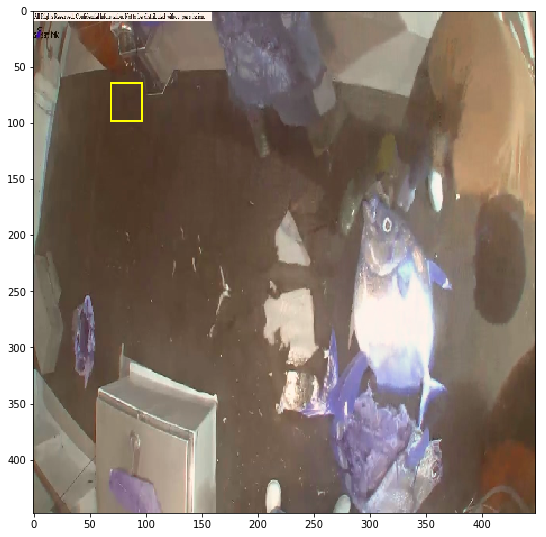

In [17]:
show_pred(9)

In [19]:
pred_p = {}
real_p = {}
for i in range(len(classes)):
    pred_p[classes[i]] = 0
    real_p[classes[i]] = 0

total = 0
for i in range(len(pred)):
    for j in range(len(classes)):
        pred_p[classes[j]] += pred[i][j]
        real_p[classes[j]] += real[i][j]

for i in range(len(classes)):
    pp = pred_p[classes[i]] / len(pred)
    rp = real_p[classes[i]] / len(pred)
    print('{} - pred: {:.4f}, real: {:.4f}, bias: {:.4f}'.format(classes[i], pp, rp, pp/rp))

ALB - pred: 0.6407, real: 0.5150, bias: 1.2441
BET - pred: 0.0306, real: 0.0620, bias: 0.4929
DOL - pred: 0.0028, real: 0.0160, bias: 0.1722
LAG - pred: 0.0102, real: 0.0370, bias: 0.2748
NoF - pred: 0.1506, real: 0.1220, bias: 1.2347
OTHER - pred: 0.0151, real: 0.0820, bias: 0.1844
SHARK - pred: 0.0118, real: 0.0300, bias: 0.3924
YFT - pred: 0.1383, real: 0.1360, bias: 1.0166


In [32]:
# c_matrix = np.zeros([len(classes), len(classes)])
c_matrix = {}

for i in range(len(classes)):
    pl = classes[i] + '_P'
    c_matrix[pl] = {}
    for j in range(len(classes)):
        tl = classes[j] + '_T'
        c_matrix[pl][tl] = 0

for i in range(len(pred)):
    predicted = classes[np.argmax(pred[i])] + '_P'
    truelabel = classes[np.argmax(real[i])] + '_T'
    c_matrix[predicted][truelabel] += 1
    
pd.DataFrame(c_matrix)

,ALB_P,BET_P,DOL_P,LAG_P,NoF_P,OTHER_P,SHARK_P,YFT_P
ALB_T,466,5,0,2,22,1,0,19
BET_T,44,6,0,0,2,0,0,10
DOL_T,4,0,1,0,0,0,0,11
LAG_T,30,0,0,4,3,0,0,0
NoF_T,8,1,0,0,113,0,0,0
OTHER_T,62,1,0,0,1,9,0,9
SHARK_T,10,6,0,0,3,0,11,0
YFT_T,48,5,0,1,0,0,0,82
